In [10]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [11]:
from oil_library import get_oil_props

In [12]:
op = get_oil_props(u'ALASKA NORTH SLOPE (MIDDLE PIPELINE)')

In [13]:
# NorthSlopeTestData

# AK North Slope (Middle Pipeline) used to test ADIOS 3 evaporation
# This is the PC data that James generates, not the distillation data

Sample=0
API=0
DensityInit = 875.94

# temperature of the PC
BP=np.asarray([313, 353, 393, 433, 473, 573, 673, 773, 873, 973, 1015])

# pressure for the distillation in mmHg
CutPressure=np.asarray([760, 760, 760, 760, 760, 760, 760, 760, 760, 760, 760])

# cumulative weight fraction PCs
Fractn = np.asarray([.03, .07, .13, .19, .25, .42, .6, .76, .88, .908, .9999])

#	Main_TestAdios
#	This program is the ADIOS II evaporation method
#	In ADIOS II the oil is reduced to a mixture of discrete components.  The volume
#	boiling point of each component are taken directly from standard distallation data.
#	The boiling point is the terminal temperature of the cut.  The final component is
#	taken as the volume of oil remaining after the last measured temperature and its
#	boiling point is found from extrapolation.  
#	The Antoine equation (see section 14-3 of Lyman) is used to derive the vapor pressure
#	from the boiling point.  Mackay's formulation for the mass transfer coefficient.
#	Euler's method is used to solve the differential equations.
#	
#													May 18, 2015
#Output1=fopen('TestResults','w');
#fprintf(Output1,'\nOutput from TestAdios with North Slope');

# different than distillation data
TempK=300.			# nominal water temp
TempF=((TempK-273.15)*9./5.) + 32.	# water temp in Farenheit
R=8.3144

Vinit=16.						# initial volume of oil
MassInit=DensityInit*Vinit      # initial mass of oil
thickness=0.001				# initial thickness
nom_Area=Vinit/thickness		# nominal surface area
D=sqrt(nom_Area)				# side of square pool
nom_U=5						# nominal wind speed 

#fprintf(Output1,'\nTemperature =#10.2e',nom_Temp)
#fprintf(Output1,'\nInitial Volume =#10.2f',Vinit)
#fprintf(Output1,'\nWind speed =#10.2f',nom_U)
#fprintf(Output1,'\nArea =#10.2f',nom_Area)
#fprintf(Output1,'\n\nhours')
#fprintf(Output1,'\tVolFrctn')

# EVAPORATION USING ADIOS II PSEUDO-COMPONENT METHOD
U=nom_U
Area=nom_Area	
#Dpower=(2*(np.sqrt(Area/np.pi)))**0.1111		# diameter of puddle to 1/9 power
Dpower=1   # should match what we are doing in ADIOS 3

delS = 8.75 + (1.987*np.log(BP))
eq15 = 0.19 * BP - 18.0
eq14 = 1./(BP - eq15) - 1./(TempK - eq15);
eq14 = delS*(BP - eq15)*(BP - eq15)*eq14/(0.97*1.987*BP)
VP = 101325. * exp(eq14)
MW = 0.04132-((1.985e-4)*BP)+(9.494e-7*BP**2) # molecular weight
crootMW = MW**0.33333

# compute the initial moles and initial mass
mass_fracs = np.insert(np.diff(Fractn), 0, Fractn[0])
mass_fracs[-1] += (1.0 - mass_fracs.sum())
i_c_mass = MassInit * mass_fracs
i_moles = i_c_mass/MW


In [14]:
# VP is the same for the same boiling point so just use one for each cut
# and compare with data generated from Robert's script
vp_gnome = op.vapor_pressure(TempK)
mask = np.logical_or(op._sara['type'] == 'Aromatics', op._sara['type'] == 'Resins')

if np.allclose(vp_gnome[mask], VP):
    print 'Vapor pressures match'

if np.allclose(op.molecular_weight[mask], MW):
    print 'Molecular weights match'

if i_c_mass.sum() == MassInit:
    print 'Sum of component masses add upto total initial mass'

print MW

Sum of component masses add upto total initial mass
[ 0.07220127  0.08955328  0.10994338  0.13337156  0.15983781  0.23929505
  0.33774029  0.45517353  0.59159477  0.74700401  0.81793812]


In [15]:
to=0					# initial time
tfhours=50.		    # final time in hours
tf=tfhours*3600.		# final time in seconds

stepsize = 10.				# size of initial time step
num_steps = int(np.ceil(tf/stepsize))
print num_steps
#num_steps = 2

time = np.zeros((num_steps,), dtype=np.float64)
c_mass = np.zeros((num_steps, len(BP)), dtype=np.float64)
c_mass[0] = i_c_mass.copy()
c_mass_exp = np.zeros((num_steps, len(BP)), dtype=np.float64)
c_mass_exp[0] = i_c_mass.copy()

tot_moles = np.zeros((num_steps,), dtype=np.float64)
tot_moles[0] = i_moles.sum()

K = .0025*(U**0.78)
c_numer = K * Area * VP
c_denom = TempK * R

for ix in xrange(1, num_steps):
    time[ix] = ix * stepsize
    numer = -c_numer * c_mass[ix-1]
    denom = c_denom * tot_moles[ix-1]
    delta_mass = numer/denom * time[ix]
    c_mass[ix] = c_mass[ix-1] + delta_mass
    c_mass[ix][c_mass[ix] < 0] = 0
    tot_moles[ix] = (c_mass[ix]/MW).sum()

    delta_exp = np.exp(numer/(c_denom * (c_mass_exp[ix-1]/MW).sum()) * time[ix])
    c_mass_exp[ix] = c_mass_exp[ix-1] * delta_exp
    c_mass_exp[ix][c_mass_exp[ix] < 0] = 0

18000


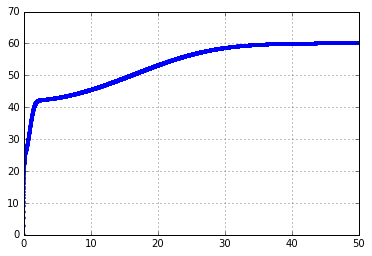

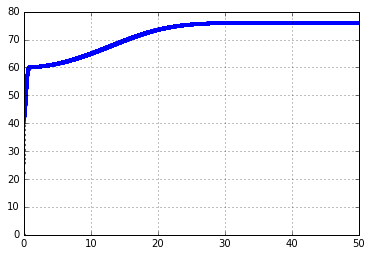

In [16]:
plt.figure()
plt.plot(time/3600.0, (1-c_mass.sum(1)/MassInit) * 100, '.b')
plt.grid()

plt.figure()
plt.plot(time/3600.0, (1-c_mass_exp.sum(1)/MassInit) * 100, '.b')
plt.grid()